# Imports

In [2]:
import random
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm

In [4]:
# FOR SVR Baseline model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [14]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [15]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [16]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

<ipython-input-16-2dcc550019b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['matchup'] = player_df['mathcup']
<ipython-input-16-2dcc550019b0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.drop(columns=['mathcup'], inplace=True)


In [17]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [18]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [19]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [20]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

<ipython-input-20-211a0410e864>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
<ipython-input-20-211a0410e864>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L


,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [21]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [22]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [23]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [24]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [25]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [26]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

<ipython-input-26-a5d1a32ab59e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
<ipython-input-26-a5d1a32ab59e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
<ipython-input-26-a5d1a32ab59e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


### Merging

In [27]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [28]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [29]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [30]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [31]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [32]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [33]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.25: EXPERIMENTAL REMOVING OF MORE COLUMNS TO SIMPLIFY THE MODEL

In [34]:
# EXPERIMENTAL:
more_columns_to_remove = \
 ['opp_team', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
  'fta', 'ftpercent', 'pfo', 'plusminus', 'matchup', 'is_home', 'date', 'min',
  'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm', 'team_3pa',
  'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent', 'team_oreb',
  'team_dreb', 'team_reb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
  'team_pfidk', 'team_plusminus', 'opp_pts', 'opp_fgm', 'opp_fga',
  'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent', 'opp_ftm', 'opp_fta',
  'opp_ftpercent', 'opp_oreb', 'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl',
  'opp_blk', 'opp_tov', 'opp_pfidk', 'opp_plusminus']
# df.drop(columns=more_columns_to_remove, inplace=True)

In [35]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

In [36]:
# Create a boolean mask
mask = (df == '-')

# Use `any` to check each column
columns_with_dash = mask.any(axis=0)

# Print the columns that contain '-'
print(columns_with_dash[columns_with_dash].index.tolist())

# Convert specific columns to strings
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(str)

# Replace '-' with '0'
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].replace('-', '0')

# Convert these columns back to floats
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(float)


['fgpercent', '3ppercent', 'ftpercent']


## 1.275: EXPERIMENTAL REMOVING OF PLAYERS THAT HAVENT PLAYED 10 GAMES AND THAT ARE NOT IN TOP 150

1.29. ADDING MORE FEATURES FOR DEBUGGING

In [37]:
players_list = list(df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)['player'])
players_dict = {players_list[i]: i for i in range(len(players_list))}
players_inv_dict = {i: players_list[i] for i in range(len(players_list))}

In [38]:
int(str(df.iloc[132]['gamedate'])[-14:-12]) * 1000 + int(str(df.iloc[132]['gamedate'])[-11:-9])

3017

In [39]:
def intify_player(player):
    return players_dict[player] / 1000

def intify_gamedate(gamedate):
    return (int(str(gamedate)[-14:-12]) * 1000 + int(str(gamedate)[-11:-9])) / 100000

In [40]:
df['int_player'] = df['player'].apply(intify_player)
df['int_gamedate'] = df['gamedate'].apply(intify_gamedate)

In [41]:
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp,int_player,int_gamedate
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,40,24,3,5,16,20,-26,28.0,0.230,0.03017
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,40,24,3,5,16,20,-26,13.0,0.455,0.03017
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,40,24,3,5,16,20,-26,17.0,0.263,0.03017
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,40,24,3,5,16,20,-26,29.0,0.240,0.03017
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,40,24,3,5,16,20,-26,1.0,0.295,0.03017


## 1.3 One-Hot Encoding

In [42]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team'])

In [43]:
## reorder the columns for visual purposes
columns_order = ['player', 'team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [44]:
df.head()

,player,team,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,...,opp_team_ORL,opp_team_PHI,opp_team_PHX,opp_team_POR,opp_team_SAC,opp_team_SAS,opp_team_TOR,opp_team_UTA,opp_team_WAS,fp
0,Payton Pritchard,BOS,2024-03-17,145,1,35,14,6,15,40.0,...,False,False,False,False,False,False,False,False,True,28.0
1,Svi Mykhailiuk,BOS,2024-03-17,145,1,23,9,3,7,42.9,...,False,False,False,False,False,False,False,False,True,13.0
2,Luke Kornet,BOS,2024-03-17,145,1,20,14,5,9,55.6,...,False,False,False,False,False,False,False,False,True,17.0
3,Sam Hauser,BOS,2024-03-17,145,1,23,30,10,13,76.9,...,False,False,False,False,False,False,False,False,True,29.0
4,Neemias Queta,BOS,2024-03-17,145,1,8,0,0,0,0.0,...,False,False,False,False,False,False,False,False,True,1.0


In [45]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'fgm', 'fga', 'fgpercent',
       ...
       'opp_team_ORL', 'opp_team_PHI', 'opp_team_PHX', 'opp_team_POR',
       'opp_team_SAC', 'opp_team_SAS', 'opp_team_TOR', 'opp_team_UTA',
       'opp_team_WAS', 'fp'],
      dtype='object', length=101)

## 1.4 Split per player



In [53]:
class NBAFantasyDataset(Dataset):
    def __init__(self, dataframe, look_back=10):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the data.
        """
        self.dataframe = dataframe
        # player + game_date logic:
        self.player_game_indices = self._get_player_game_indices()
        # for normalization:
        self.scaler = StandardScaler()
        self._normalize_features()
        # for "last 10 game" approach:
        self.look_back = look_back

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'int_player', 'int_gamedate', 'date', 'matchup'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)

    def _get_player_game_indices(self):
        """Get a list of tuples indicating the start and end indices of each player's games."""
        player_game_indices = []
        players = self.dataframe['player'].unique()
        count = 0
        for player in players:
            count += 1
            player_data = self.dataframe[self.dataframe['player'] == player]
            #player_data = player_data.sort_values(by='days_since').reset_index(drop=True) # im not sure
            for i in range(10, len(player_data)):
                start_index = player_data.index[i-10]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        features = player_data.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'matchup', 'date']).values
        # features = features.replace('-', 0).astype(float)
        target = self.dataframe.iloc[end_index]['fp']
        return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


class NBAFantasyDatasetFlat(Dataset):
    def __init__(self, dataframe, look_back=10):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the data.
        """
        self.dataframe = dataframe
        # player + game_date logic:
        self.player_game_indices = self._get_player_game_indices()
        # for normalization:
        self.scaler = StandardScaler()
        self._normalize_features()
        # for "last 10 game" approach:
        self.look_back = look_back

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'int_player', 'int_gamedate', 'date', 'matchup'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)

    def _get_player_game_indices(self):
        """Get a list of tuples indicating the start and end indices of each player's games."""
        player_game_indices = []
        players = self.dataframe['player'].unique()
        count = 0
        for player in players:
            count += 1
            player_data = self.dataframe[self.dataframe['player'] == player]
            #player_data = player_data.sort_values(by='days_since').reset_index(drop=True) # im not sure
            for i in range(10, len(player_data)):
                start_index = player_data.index[i-10]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        # Flatten the last 10 games' features into one long vector
        flattened_features = player_data.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'matchup', 'date']).values.flatten()
        target = self.dataframe.iloc[end_index]['fp']
        return torch.tensor(flattened_features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [54]:
# sdf = df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True)
# print(sdf.head())

In [55]:
def collate_fn(batch):
    """
    Custom collate function for handling variable-length sequences.
    """
    features, targets = zip(*batch)
    # Pad the sequences to the maximum length in the batch
    features_padded = nn.utils.rnn.pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    return features_padded, targets

In [56]:
batch_size = 32 # we can change this if needed

# Create a DataLoader
dataset = NBAFantasyDataset(df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Create DataLoader (Flattened Featured for SVR)
dataset_flat = NBAFantasyDatasetFlat(df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True))
dataloader_flat = DataLoader(dataset_flat, batch_size=32, shuffle=True)  # Batch size of 1 since we're treating each sample independently

## 1.5 Train-Test Split

In [57]:
# Define the split sizes
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size
test_indices = random.sample(range(20000), test_size)

train_dataset_flat, test_dataset_flat = random_split(dataset_flat, [train_size, test_size])
train_dataloader_flat = DataLoader(train_dataset_flat, batch_size=32, shuffle=True)
test_dataloader_flat = DataLoader(test_dataset_flat, batch_size=32, shuffle=True)


# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)

# 2. Comparing Results and Conclusion

## 2.1: Getting Predictions From a Reputable Website

In [5]:
# Base URL for the data
base_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/'

# File names for each month
file_names = ['fpdata_March.csv', 'fpdata_Feb.csv', 'fpdata_Jan.csv', 'fpdata_Dec.csv']

# Initialize the list to store dataframes
pw_dfs = []

# Loop through the file names, download the data, and append to the list
for file_name in file_names:
    file_url = base_url + file_name
    pw_df = pd.read_csv(file_url)
    pw_dfs.append(pw_df)

# Concatenate all dataframes into one
dirty_predictor_website_df = pd.concat(pw_dfs, ignore_index=True)
dirty_predictor_website_df.head() # it's not clean bc of NaNs, whose values appear at the bottom bc of bad data structure

,web-scraper-order,web-scraper-start-url,Rank,Name,Team,Pos,OPP,PTS,REB,AST,...,FG_percent,FT_percent,3P_percent,FTM,2PM,3PM,Turnover,MIN,FPts,page
0,1712980617-1,https://fantasydata.com/nba/fantasy-basketball...,1.0,Domantas Sabonis\n \n \n \n \n...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1712980617-2,https://fantasydata.com/nba/fantasy-basketball...,2.0,Tyrese Haliburton\n \n \n \n \...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1712980617-3,https://fantasydata.com/nba/fantasy-basketball...,3.0,Anthony Edwards\n \n \n \n \n ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1712980617-4,https://fantasydata.com/nba/fantasy-basketball...,4.0,Jalen Brunson\n \n \n \n \n ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1712980617-5,https://fantasydata.com/nba/fantasy-basketball...,5.0,De'Aaron Fox\n \n \n \n \n ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def clean_data(data):
    """
    The logic behind this algorithm is very complex.
    I sold my soul to the devil to get the alignment problem right.
    """
    # Identifying rows with player names and stats
    player_indices = data.index[data['Name'].notna()].tolist()
    stats_indices = data.index[data['PTS'].notna()].tolist()

    segments = []
    current_segment = {'players': [], 'stats': []}

    # Initialize flags to track when a new segment needs to be started
    start_new_segment = True

    # Collect indices into segments
    for i in tqdm(range(len(data))):
        if i in player_indices:
            if start_new_segment:
                # If a new segment is needed, start it
                if current_segment['players'] or current_segment['stats']:
                    segments.append(current_segment)
                    current_segment = {'players': [], 'stats': []}
                start_new_segment = False  # Reset the flag
            current_segment['players'].append(i)
        elif i in stats_indices:
            current_segment['stats'].append(i)
            start_new_segment = True  # New segment will start after this stats block

    # Add the last segment
    if current_segment['players'] or current_segment['stats']:
        segments.append(current_segment)

    # Process each segment separately
    paired_data = []
    for segment in tqdm(segments):
        p_idx = 0
        s_idx = 0
        while p_idx < len(segment['players']) and s_idx < len(segment['stats']):
            paired_data.append((segment['players'][p_idx], segment['stats'][s_idx]))
            p_idx += 1
            s_idx += 1


    # Creating a structured DataFrame
    paired_df = pd.DataFrame({
        'web-scraper-order': [data.iloc[p[0]]['web-scraper-order'] for p in paired_data],
        'web-scraper-start-url': [data.iloc[p[0]]['web-scraper-start-url'] for p in paired_data],
        'Name': [data.iloc[p[0]]['Name'] for p in paired_data],
        'Team': [data.iloc[p[1]]['Team'] for p in paired_data],
        'Pos': [data.iloc[p[1]]['Pos'] for p in paired_data],
        'OPP': [data.iloc[p[1]]['OPP'] for p in paired_data],
        'PTS': [data.iloc[p[1]]['PTS'] for p in paired_data],
        'REB': [data.iloc[p[1]]['REB'] for p in paired_data],
        'AST': [data.iloc[p[1]]['AST'] for p in paired_data],
        'BLK': [data.iloc[p[1]]['BLK'] for p in paired_data],
        'STL': [data.iloc[p[1]]['STL'] for p in paired_data],
        'FG_percent': [data.iloc[p[1]]['FG_percent'] for p in paired_data],
        'FT_percent': [data.iloc[p[1]]['FT_percent'] for p in paired_data],
        '3P_percent': [data.iloc[p[1]]['3P_percent'] for p in paired_data],
        'FTM': [data.iloc[p[1]]['FTM'] for p in paired_data],
        '2PM': [data.iloc[p[1]]['2PM'] for p in paired_data],
        '3PM': [data.iloc[p[1]]['3PM'] for p in paired_data],
        'Turnover': [data.iloc[p[1]]['Turnover'] for p in paired_data],
        'MIN': [data.iloc[p[1]]['MIN'] for p in paired_data],
        'FPts': [data.iloc[p[1]]['FPts'] for p in paired_data]
    })
    return paired_df

In [7]:
def extract_date(url):
    from urllib.parse import urlparse, parse_qs
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    return query_params.get('date', [None])[0]

In [8]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [9]:
predictor_website_df = clean_data(dirty_predictor_website_df)

100%|██████████| 156/156 [00:00<00:00, 10740.33it/s]


In [10]:
# Clean 'Name' column
predictor_website_df['Name'] = predictor_website_df['Name'].str.extract(r'([^\n]+)')

# Extract 'Date' from URL
predictor_website_df['Date'] = predictor_website_df['web-scraper-start-url'].apply(extract_date)
predictor_website_df['Date'] = pd.to_datetime(predictor_website_df['Date'], format='%m-%d-%Y')

# Split REB into OREB and DREB for our convention
predictor_website_df['OREB'] = 0
predictor_website_df['DREB'] = predictor_website_df['REB']

In [11]:
# Mapping of current column names to the column names we have
column_mapping = {
    'Name': 'player',
    'Team': 'team',
    'Date': 'gamedate',
    'PTS': 'pts',
    'OREB': 'oreb',
    'DREB': 'dreb',
    'AST': 'ast',
    'BLK': 'blk',
    'STL': 'stl',
    '3PM': '3pm',
    'Turnover': 'tov',
    'MIN': 'minuters'
}
predictor_website_df = predictor_website_df[list(column_mapping.keys())]
predictor_website_df.rename(columns=column_mapping, inplace=True)

# Calculate fantasy points, the way we defined them
predictor_website_df['fp'] = predictor_website_df.apply(calculate_fantasy_points, axis=1)

<ipython-input-11-65d3b88f3f91>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor_website_df.rename(columns=column_mapping, inplace=True)


In [12]:
predictor_website_df.head()

,player,team,gamedate,pts,oreb,dreb,ast,blk,stl,3pm,tov,minuters,fp
0,Domantas Sabonis,SAC,2024-03-18,19.99,0,13.65,8.16,0.60,0.94,0.44,2.94,35.0,33.165
1,Tyrese Haliburton,IND,2024-03-18,23.02,0,4.38,12.40,0.74,1.28,3.21,2.64,35.0,32.295
2,Anthony Edwards,MIN,2024-03-18,27.82,0,5.89,5.25,0.82,1.30,2.68,2.73,36.0,27.900
3,Jalen Brunson,NY,2024-03-18,27.68,0,3.90,6.46,0.20,1.11,2.71,2.53,35.0,25.645
4,De'Aaron Fox,SAC,2024-03-18,25.51,0,4.34,5.64,0.41,1.62,2.56,2.55,33.0,25.525


In [13]:
len(predictor_website_df)

20983

## 5.2: Evaluating the Predictions From a Reputable Website

In [46]:
df.head()

,player,team,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,...,opp_team_ORL,opp_team_PHI,opp_team_PHX,opp_team_POR,opp_team_SAC,opp_team_SAS,opp_team_TOR,opp_team_UTA,opp_team_WAS,fp
0,Payton Pritchard,BOS,2024-03-17,145,1,35,14,6,15,40.0,...,False,False,False,False,False,False,False,False,True,28.0
1,Svi Mykhailiuk,BOS,2024-03-17,145,1,23,9,3,7,42.9,...,False,False,False,False,False,False,False,False,True,13.0
2,Luke Kornet,BOS,2024-03-17,145,1,20,14,5,9,55.6,...,False,False,False,False,False,False,False,False,True,17.0
3,Sam Hauser,BOS,2024-03-17,145,1,23,30,10,13,76.9,...,False,False,False,False,False,False,False,False,True,29.0
4,Neemias Queta,BOS,2024-03-17,145,1,8,0,0,0,0.0,...,False,False,False,False,False,False,False,False,True,1.0


In [63]:
import matplotlib

def evaluate_prediction_website(df, predictor_website_df, test_indices, threshold):
    actual_fps = []
    predicted_fps = []
    hits = 0

    for idx in test_indices:
        # Get the name and date from predictor_website_df
        predicted_name = predictor_website_df.iloc[idx]['player']
        predicted_date = predictor_website_df.iloc[idx]['gamedate']

        # Get the predicted Fantasy Points
        predicted_fp = predictor_website_df.iloc[idx]['fp']

        # Find the corresponding actual entry in df
        actual_entry = df[(df['player'] == predicted_name) & (df['gamedate'] == predicted_date)]

        if not actual_entry.empty:
            actual_fp = actual_entry.iloc[0]['fp']  # Taking the first matching entry

            # Used following two lines to confirm we are looking at the same player and game
            #if actual_entry.iloc[0]['team'] != predictor_website_df.iloc[idx]['team'] and actual_fp >= 5:
                #print("Mismatch of", actual_entry.iloc[0]['team'], " vs ", predictor_website_df.iloc[idx]['team'])

            # Collect data for MSELoss and plotting
            actual_fps.append(actual_fp)
            predicted_fps.append(predicted_fp)

            # Check if prediction is within the threshold of actual
            if abs(predicted_fp - actual_fp) <= threshold:
                hits += 1

    # Calculate accuracy only if we have at least one match
    accuracy = hits / len(actual_fps) if actual_fps else 0

    # Calculate MSELoss only if we have matches
    mse_loss = mean_squared_error(actual_fps, predicted_fps) if actual_fps else None

    # Plotting actual vs predicted
    if actual_fps:
        # Enable LaTeX rendering in plots
        matplotlib.rcParams['text.usetex'] = True
        matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

        # Set classic style for plots
        plt.style.use('classic')

        # Assuming 'actual_fps' and 'predicted_fps' are defined arrays or lists of actual and predicted fantasy points
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_fps, predicted_fps, alpha=0.5, edgecolor='k', facecolor='skyblue')  # Adding edgecolor for better visibility
        plt.plot([min(actual_fps), max(actual_fps)], [min(actual_fps), max(actual_fps)], color='red', linestyle='--', linewidth=2)  # Diagonal line for perfect predictions
        plt.xlabel('Actual Fantasy Points')
        plt.ylabel('Predicted Fantasy Points')
        plt.title('Actual vs. Predicted Fantasy Points From a Reputable Website')
        plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')
        plt.minorticks_on()
        plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
        plt.show()

    else:
        print("No matching data found for predictions.")

    return accuracy, mse_loss

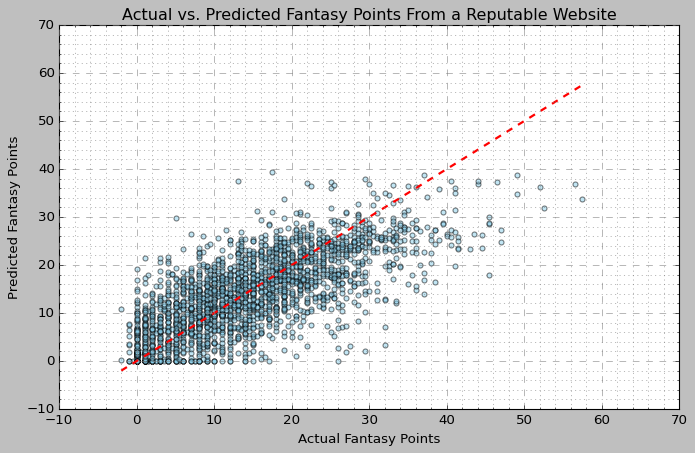

Reputable Prediction Website Accuracy: 0.5608373310074138, MSE Loss: 48.46868736371566


In [64]:
accuracy, mse_loss = evaluate_prediction_website(df, predictor_website_df, test_indices=test_indices, threshold=5)
print(f"Reputable Prediction Website Accuracy: {accuracy}, MSE Loss: {mse_loss}")

EnrichedLSTM proves to be almost as good as the predictions from the reputable website